In [518]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import IndexSlice as ix

import torch
import torch.nn as nn
import yfinance

In [148]:
TARGET = "N225"
TICKERS = {
    "^N225": "Nikkei 225",
    "^GSPC": "S&P 500",
    "^TNX": "US10Y Interest Rate",
    "DX-Y.NYB": "ICE Dollar Index",
}

# Data

In [260]:
# Get Daily OHLC from YFinance
from cqf.data.yfinance import get_daily_ohlc
ohlc = pd.concat([get_daily_ohlc(ticker) for ticker in TICKERS])

display(
    "Table1: Feature Tickers List",
    pd.DataFrame([TICKERS]).T.reset_index().set_axis(["YFinance Ticker", "Name"], axis=1),
    
    "Table2: Raw Data Periods",
    ohlc.reset_index().groupby("ticker").date.agg(["min", "max", "count"]).rename(TICKERS)
)

'Table1: Feature Tickers List'

,YFinance Ticker,Name
0,^N225,Nikkei 225
1,^GSPC,S&P 500
2,DX-Y.NYB,ICE Dollar Index
3,^TNX,US10Y Interest Rate


'Table2: Raw Data Periods'

,min,max,count
ticker,,,
ICE Dollar Index,2010-01-04,2023-12-29,3521
S&P 500,2010-01-04,2023-12-29,3522
Nikkei 225,2010-01-04,2023-12-29,3425
US10Y Interest Rate,2010-01-04,2023-12-29,3519


# Features/Labels

- OC
- HL
- HC
- LC
- OS
- V

In [471]:
# calculate features
from cqf.preprocess.feature import calc_ohlcv_features

features = pd.concat([calc_ohlcv_features(ohlc.query("ticker==@ticker")) for ticker in ohlc.ticker.unique()], axis=1)
label = ohlc.query("ticker=='^N225'").assign(oc = lambda x: (x.close-x.open)>0).shift(-1)["oc"].dropna().astype(int)

# To stack format
features_stack = (
    features
    .stack().rename("value").reset_index()
    .assign(
        ticker=lambda x: x.feature.str.split("_").str[-1].replace(TICKERS), 
        feature=lambda x: x.feature.str.split("_").str[0]
    )
    .set_index(["date", "ticker", "feature"]).value.unstack(level=[1, 2])
)

# EDA

## Univariate basic stats

In [253]:
display(
    "Table3: Basic Statistics of Raw Feature Values",
    features_stack.describe().T.style.format(precision=2),
)

'Table3: Basic Statistics of Raw Feature Values'

## Multivariate basic stats

'Fig.1: Scatter Matrix of Features of Nikkei 225'

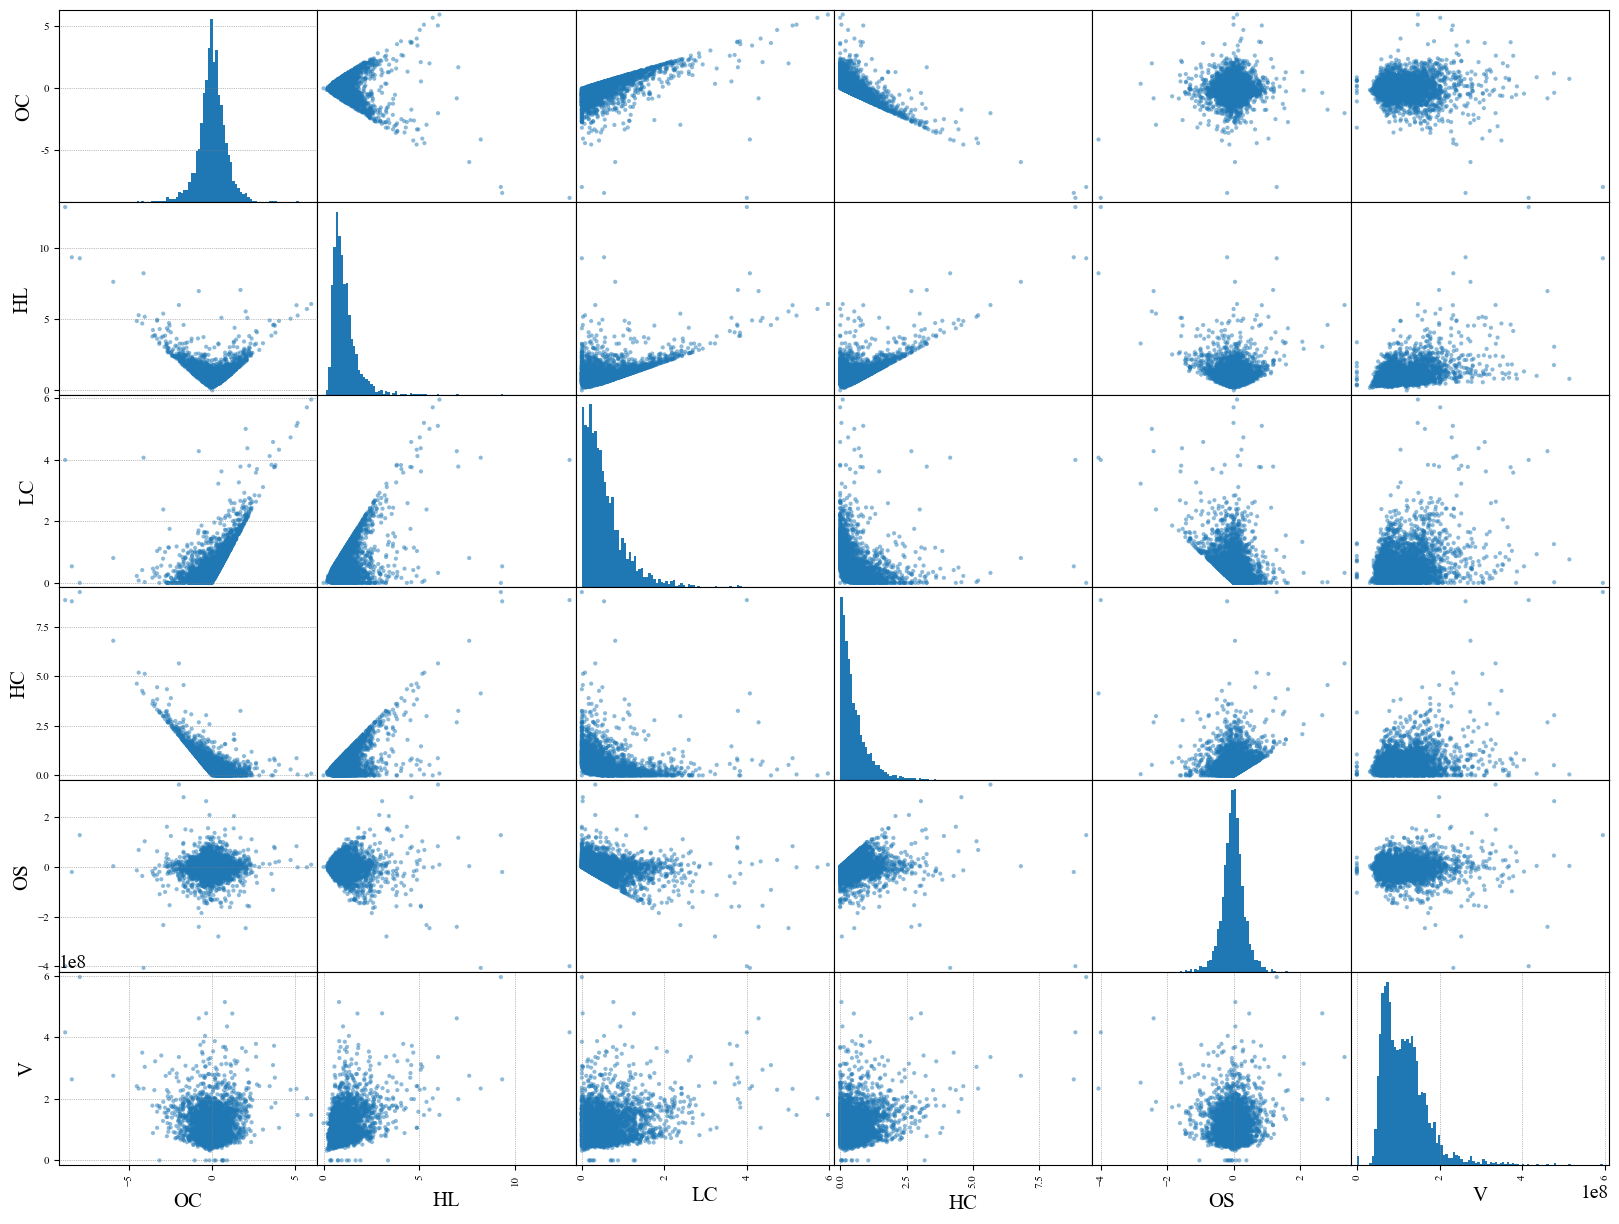

In [257]:
# Scatter matrix
display("Fig.1: Scatter Matrix of Features of Nikkei 225")

features_n225 = features_stack["Nikkei 225"]
pd.plotting.scatter_matrix(features_n225, hist_kwds={"bins": 100}, figsize=(20, 15), grid=True);

In [259]:
# Correlation matrix
display(
    "Fig.2: Correlation Matrix of Raw Feature Values",
    features_stack.corr()
    .replace(1, np.nan).style.format(precision=2).background_gradient(vmin=-1, vmax=1, cmap="RdBu")
)

'Fig.2: Correlation Matrix of Raw Feature Values'

# Feature Transformation

## For bell-form features

- rolling
- deMean, deStd

In [473]:
from cqf.preprocess import apply_rolling_lognormalize1
features1 = apply_rolling_lognormalize1(features_stack.loc[:, ix[:, ["OC", "OS"]]])

## For all positive features

- log(1+f)
- rolling

In [474]:
from cqf.preprocess import apply_rolling_lognormalize2
features2 = apply_rolling_lognormalize2(features_stack.loc[:, ix[:, ["V", "HL"]]])

In [442]:
# from sklearn.preprocessing import PowerTransformer
# log.rolling(window).apply(transform)

In [501]:
# Concatenate
features_norm = pd.concat([features1, features2], axis=1).fillna(0)

# Train

## Train/Test splitting

In [775]:
TRAIN_ST = "2011-01-01"
TRAIN_ET = "2017-12-30"
# VALID_ST = "2017-01-01"
# VALID_ET = "2017-12-30"
TEST_ST = "2018-01-01"
TEST_ET = "2023-12-30"

In [904]:
# Train/test split
y = label
x = features_norm.loc[label.index]

y_train = y.loc[TRAIN_ST:TRAIN_ET]
x_train = x.loc[TRAIN_ST:TRAIN_ET]
y_test = y.loc[TEST_ST:TEST_ET]
x_test = x.loc[TEST_ST:TEST_ET]

In [1089]:
# Dataset
from cqf.model.dataset import TimeSeriesDataset
from torch.utils.data import DataLoader
n_lookback = 30
train_dataset = TimeSeriesDataset(x=x_train, y=y_train, n_lookback=n_lookback, target_months=[1, 2, 4, 5, 7, 8, 10, 11])
valid_dataset = TimeSeriesDataset(x=x_train, y=y_train, n_lookback=n_lookback, target_months=[3, 6, 9, 12])
test_dataset = TimeSeriesDataset(x=x_test, y=y_test, n_lookback=n_lookback)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

In [1086]:
# Model setup
from cqf.model.cnn import SimpleCNN
model = SimpleCNN(
    n_channel=x_train.columns.get_level_values(0).nunique(),
    width=x_train.columns.get_level_values(1).nunique()
)  # [B, C, H, W] = [:, #Ticker, #Lookback, #FeaturePerTicker]

# Loss&Optimizer
criterion = nn.BCELoss()  # 2値分類の場合はnn.BCELoss()を使用することも可能
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Training Loop
num_epochs = 50
train_log = []

patience = 100
best_val_loss = np.inf
counter = 0

for epoch in range(num_epochs):
    # Train Loop
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Validation Loop
    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, labels in valid_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    # バリデーションセットの性能が改善しない場合のカウンター更新
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1

    # terminate training loop
    if counter >= patience:
        print(f'Early stopping at epoch {epoch}')
        break
    
    train_log.append({
        "epoch": epoch,
        "train_loss": running_loss / len(train_loader),
        "val_loss": val_loss/len(valid_loader),
    })
    # print(f'Epoch {epoch+1}/{num_epochs}, {train_log[-1]}')

<AxesSubplot:>

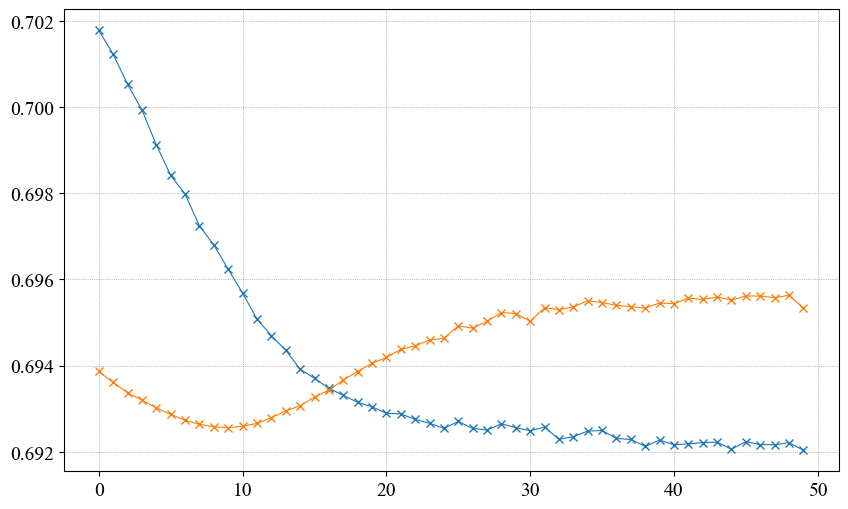

In [1087]:
pd.DataFrame(train_log).train_loss.plot(marker="x")
pd.DataFrame(train_log).val_loss.plot(marker="x")

In [1125]:
# test
predictions = []
with torch.no_grad():
    for inputs, labels in test_loader:
        predictions.append(model(inputs).numpy())
predictions = np.concatenate(predictions).reshape(-1,)

pd.DataFrame({"pred": predictions, "label": y_test.values[n_lookback-1:]}).corr()

,pred,label
pred,1.00000,-0.04137
label,-0.04137,1.00000


In [1128]:
# train
train_dataset = TimeSeriesDataset(x=x_train, y=y_train, n_lookback=n_lookback)
train_loader = DataLoader(train_dataset, batch_size=64)

# DataLoader
predictions = []
with torch.no_grad():
    for inputs, labels in train_loader:
        predictions.append(model(inputs).numpy())
predictions = np.concatenate(predictions).reshape(-1,)

pd.DataFrame({"pred": predictions, "label": y_train.values[n_lookback-1:]}).corr()

,pred,label
pred,1.000000,0.021103
label,0.021103,1.000000


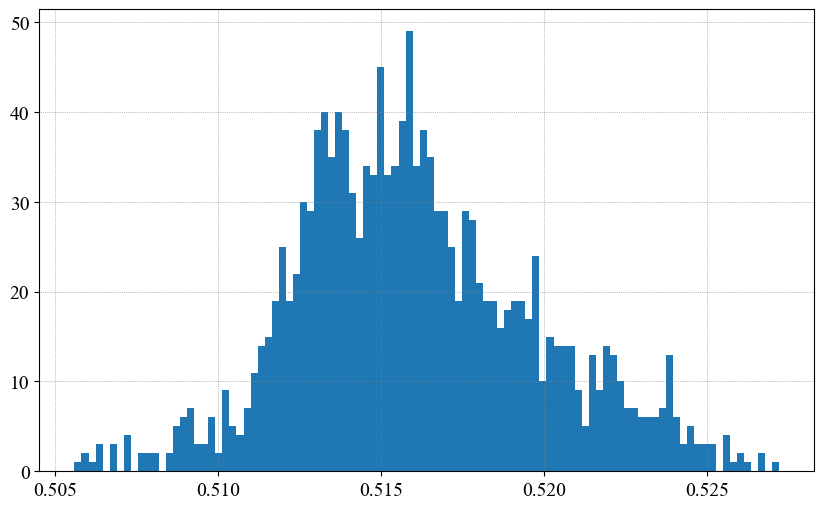

In [1129]:
plt.hist(predictions, bins=100);

In [1107]:
y_train.value_counts()

1    744
0    727
Name: oc, dtype: int64

In [1111]:
y_train.sum() / y_train.shape[0]

0.5057783820530252

# Evaluation

In [6]:
# !jupyter nbconvert Untitled.ipynb --to html --template lab --HTMLExporter.theme dark

[NbConvertApp] Converting notebook Untitled.ipynb to html
[NbConvertApp] Writing 660418 bytes to Untitled.html
